

THis is an update of `crms_repr-celltype-pattern_rec`, `crms_representation-cell-type-specific.ipynb`, focused on find patterns found in the data,

05/11/2020

test cell-type specific prediction

todo
- test model performance with only certan parameters
- edit the model type
- set up sequence information

# 0. startup


In [10]:
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import itertools
from scipy.stats.stats import pearsonr

from collections import Counter, defaultdict
import time
from sklearn.preprocessing import OneHotEncoder
import matplotlib
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing, metrics
from scipy import interp
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
save_dir = '../data/processed/fig6_cancer'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [13]:
THRES=1

In [14]:
# hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
# hoco_annon = pd.read_table(hoco_annon_file,header=0)
# hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
# hoco_motif_t|o_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
# tfs = list(hoco_annon['Transcription factor'])

# 1. create representation of crms (numerical format)
- one hot encoding for each of downstream machine learning
- save in `networks/representations`
- see `crms_representation.ipynb`

2. activity by contact
what is the correlation between expression of a gene and 
- the number of unique loops it contains
- sum of read counts aggregated over all loops
- number of atac regions



# 2. Machine learning expression



##  1. Data preprocessing and importing

iteracte through
- scc vs gds
- melanoma lines vs mc

In [17]:
# # option 1: SCC
# save_prefix = 'comb_scc_vs_normal' # comb >~ sep > prom > sumd
# data_type = 'comb'

# sel_tissues = ['A431-CTRLi','CAL27-CTRLi','GDSD0','GDSD3','GDSD6','SCC13-CTRLi']
# label = [True, True, False, False, False, True]
# # sel_tissues = ['A431-CTRLi','CAL27-CTRLi','GDSD0','GDSD3','GDSD6','SCC13-CTRLi']
# # label = [True, True, False, False, False, True]

In [91]:
# option 2: melanoma
save_prefix = 'comb_mc_vs_normal' # comb >~ sep > prom > sumd
data_type = 'comb'

sel_tissues = ['COLO_SCR_DMSO','Melanocytes','SKMEL5_SCR_DMSO','WM_SCR_DMSO']
label = [True, False, True, True]


In [92]:
%%time
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
data_all = data_all[data_all.tissue.isin(sel_tissues)]
print(data_all.shape)
# filter for crms with data, 
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
print(data_all.shape)


(74433, 686)
(25770, 686)
CPU times: user 49.8 s, sys: 13.6 s, total: 1min 3s
Wall time: 52.5 s


In [94]:
exp_label = list(data_all.exp.values)
exp_label_bin  = np.array((data_all.exp>THRES).values)



preprocess genes by converting into number

In [95]:
genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)

In [96]:
len(np.unique(genes_all))

11956

 preprocess tissues

In [97]:
label_mapping_dict = dict(zip(sel_tissues, label))

tissue_labels = data_all.tissue.values
tissue_bin_labels =  data_all.tissue.map(label_mapping_dict).values
tissue_labels.shape

(25770,)

In [100]:
Counter(tissue_bin_labels) # more like disease labels

Counter({True: 18883, False: 6887})

In [101]:
Counter(tissue_labels)

Counter({'COLO_SCR_DMSO': 8544, 'Melanocytes': 6887, 'WM_SCR_DMSO': 10339})

In [102]:
## only tfs
data_all.drop(['tissue','exp','num_loop_counts','num_loops','num_atac_regions_pro','num_atac_regions_loop'],axis=1,inplace=True)

data_all.shape




(25770, 680)

In [103]:
# ## normal version
# data_all.drop('tissue',axis=1,inplace=True)
# data_all['gene_num'] = genes_num_all
   
# data_all.shape




In [104]:
# preprocessing, remove zero variance columns, and scale rest of columns 
    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(25770, 680) (25770, 548) 548
(25770, 548) (25770, 548)


## 2A: Classification:
Random Forest, SVM, etc
### 2A.0: Random Forest basic testing:


In [105]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm,tissue_bin_labels,# tissue_labels,
                                                                            test_size = 0.25, random_state = 80)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())
Counter(test_labels)

Training Features Shape: (19327, 548)
Training Labels Shape: (19327,)
Testing Features Shape: (6443, 548)
Testing Labels Shape: (6443,)


Counter({False: 1678, True: 4765})

In [106]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 1min 4s, sys: 360 ms, total: 1min 4s
Wall time: 4.93 s


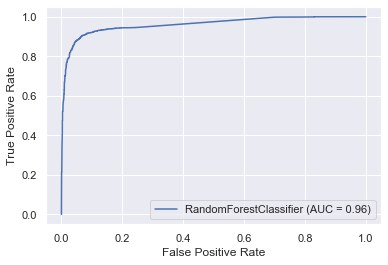

In [107]:
plot_roc_curve(model, test_features, test_labels) 

In [108]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.to_csv(os.path.join(save_dir, save_prefix+'_feature_importance.csv'))

# Display
fi.head(10)

,feature,importance
534,KLF15_loop,0.065557
332,SP4_loop,0.059736
537,SALL4_loop,0.047431
448,SOX2_loop,0.022054
544,TFAP2B_loop,0.018557
225,EGR2_loop,0.018170
528,SOX10_loop,0.017235
436,BCL11A_loop,0.016697
387,ZNF394_loop,0.013845
364,VEZF1_loop,0.013715


In [109]:
# save_prefix = 'comb_scc_vs_normal' # comb >~ sep > prom > sumd


In [110]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # # Calculate roc auc
# roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
# print(roc_value)

0.9157224895235139


In [31]:
test_labels_num = np.vectorize(label_mapping_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


TypeError: '>=' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(model.classes_[i], roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), rf_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print('micro average', roc_auc["micro"])

In [ ]:
normal_tissues_dict

In [ ]:
# saving
auc_df = pd.DataFrame.from_dict({'tissue':list(model.classes_)+['micro'],'LOO-AUROC': list(roc_auc.values())},orient='columns')
auc_df.to_csv(os.path.join(save_dir, save_prefix+'_auc_tissue.csv'))



In [ ]:
# saving tpr 
pd.DataFrame.from_dict({'fpr':fpr["micro"],'tpr': tpr["micro"]},orient='columns').to_csv(os.path.join(save_dir, save_prefix+'_auc_curve_values.csv'))

In [ ]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
np.std(list(roc_auc.values()))

In [ ]:
conf_mat = confusion_matrix(test_labels, rf_predictions)
df_confmat = pd.DataFrame(conf_mat, index = model.classes_,
                  columns = model.classes_)
display(df_confmat)

In [ ]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat/df_confmat.sum(axis=0), annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, save_prefix + '_df_confmat.pdf'),pad_inches=0.4)

### 2A.1 - testing amount of data



In [420]:
# def test_data_amt(data_mat, label_arr, perc_acc, )

In [ ]:
%%time
tot_data = len(data_all_norm)
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm[chosen_data_idx,:], 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)


0.005 780 0.7549947042533854
0.01 1560 0.7519477109679623
0.02 3121 0.774609297159982
0.04 6242 0.8183147728046894
0.08 12485 0.8405256923351875
0.16 24971 0.8445235982016381
0.25 39017 0.8538302122074904
0.32 49942 0.8623398896617002
0.5 78035 0.8756979172922983
0.75 117053 0.8841522574773416


In [ ]:
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, save_prefix+'_eval_df.csv'))

In [231]:

data_chosen

array([[6.72013936e-05, 6.09396059e-01],
       [5.85279991e-03, 2.87529684e-01],
       [3.37478531e-05, 2.31692446e-01],
       ...,
       [8.46639455e-05, 6.21141133e-01],
       [6.37677457e-06, 8.69392208e-01],
       [2.94312672e-06, 5.04460561e-02]])

In [327]:
# %%time
# rna info only
tot_data = len(data_all_norm)
column_chosen =[0,data_all_norm.shape[1]-1] # exp, num_gene
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    data_chosen = data_all_norm[chosen_data_idx,:]
    data_chosen = data_chosen[:,column_chosen].reshape((chosen_data_len, len(column_chosen)))

    train_features, test_features, train_labels, test_labels = train_test_split(data_chosen, 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, 'rna_eval_df.csv'))

0.005 166 0.5
0.01 332 0.4939747826213819
0.02 664 0.4983320747002378
0.04 1329 0.4854180617596844
0.08 2659 0.48552990531581025
0.16 5318 0.4803355500260448
0.25 8310 0.45920928930229304
0.32 10637 0.453524579235364
0.5 16621 0.4440088973902732
0.75 24932 0.42161237176574873
1 33243 0.4247720815122859


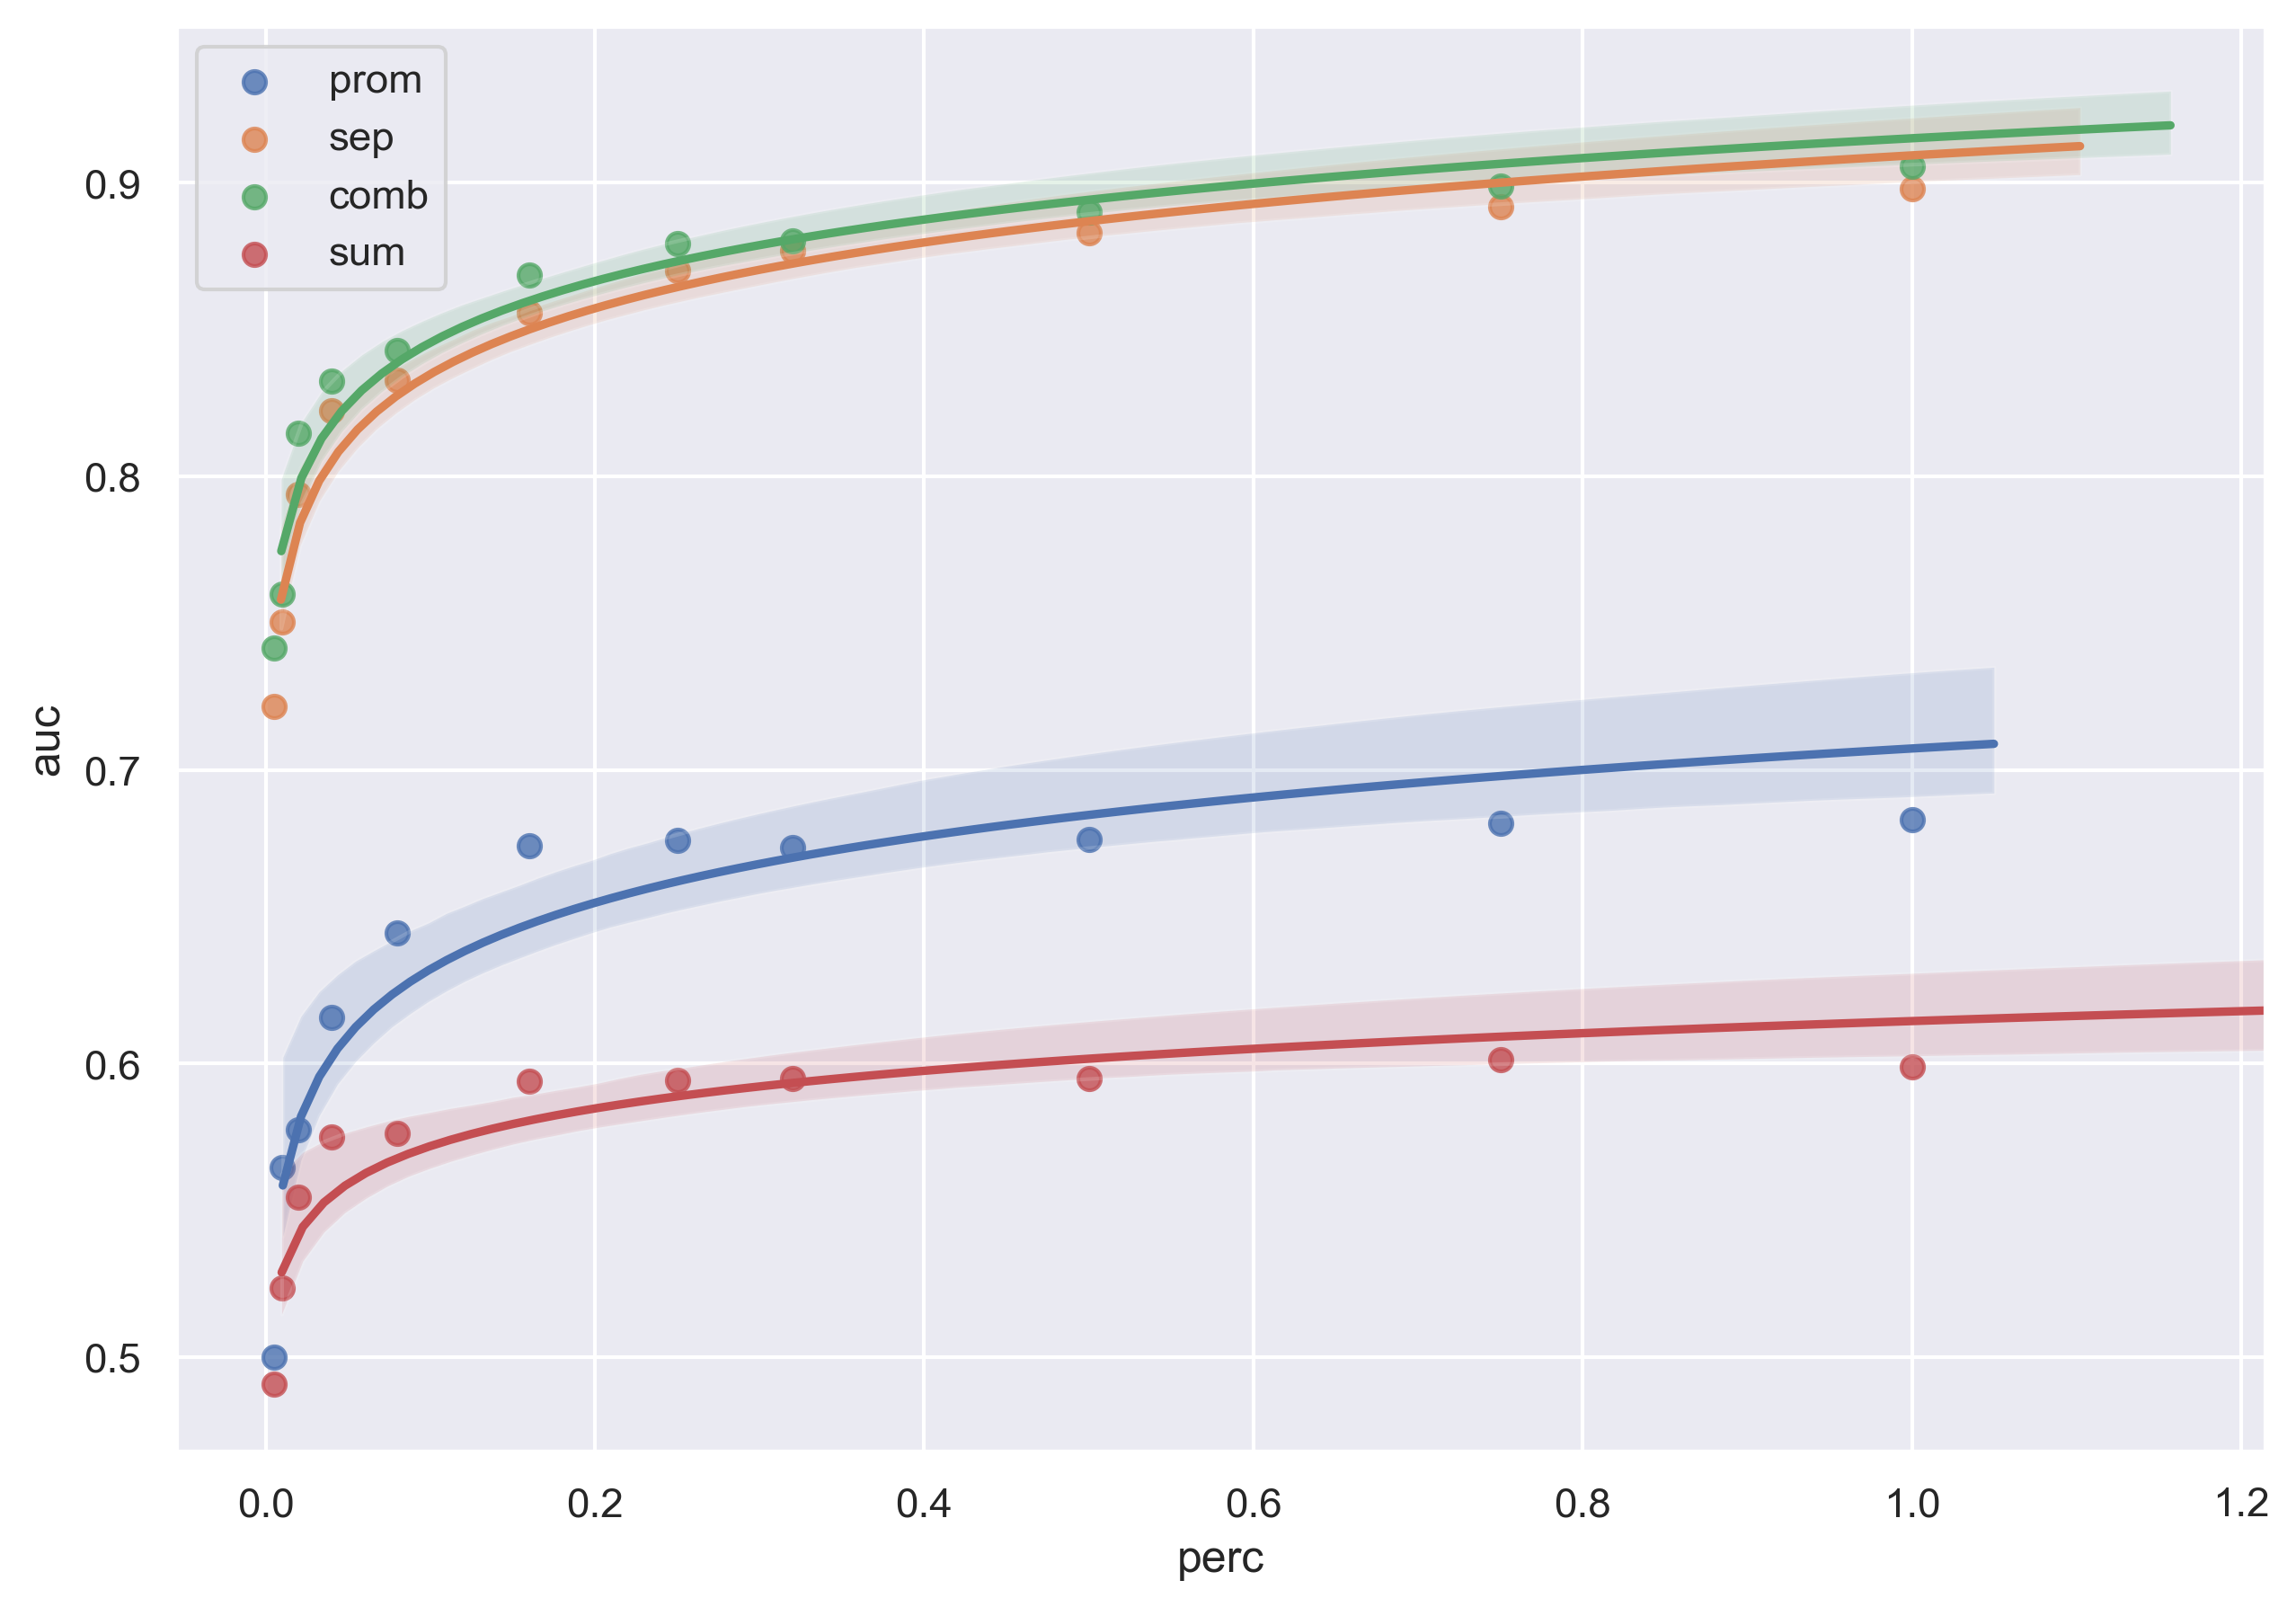

In [185]:
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
# type_to_legend_mapping = {
#     'sep':a
# }
for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_')[0]
    eval_df = pd.read_csv(filepath)
    sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type.pdf'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label='tf_with_hichip')

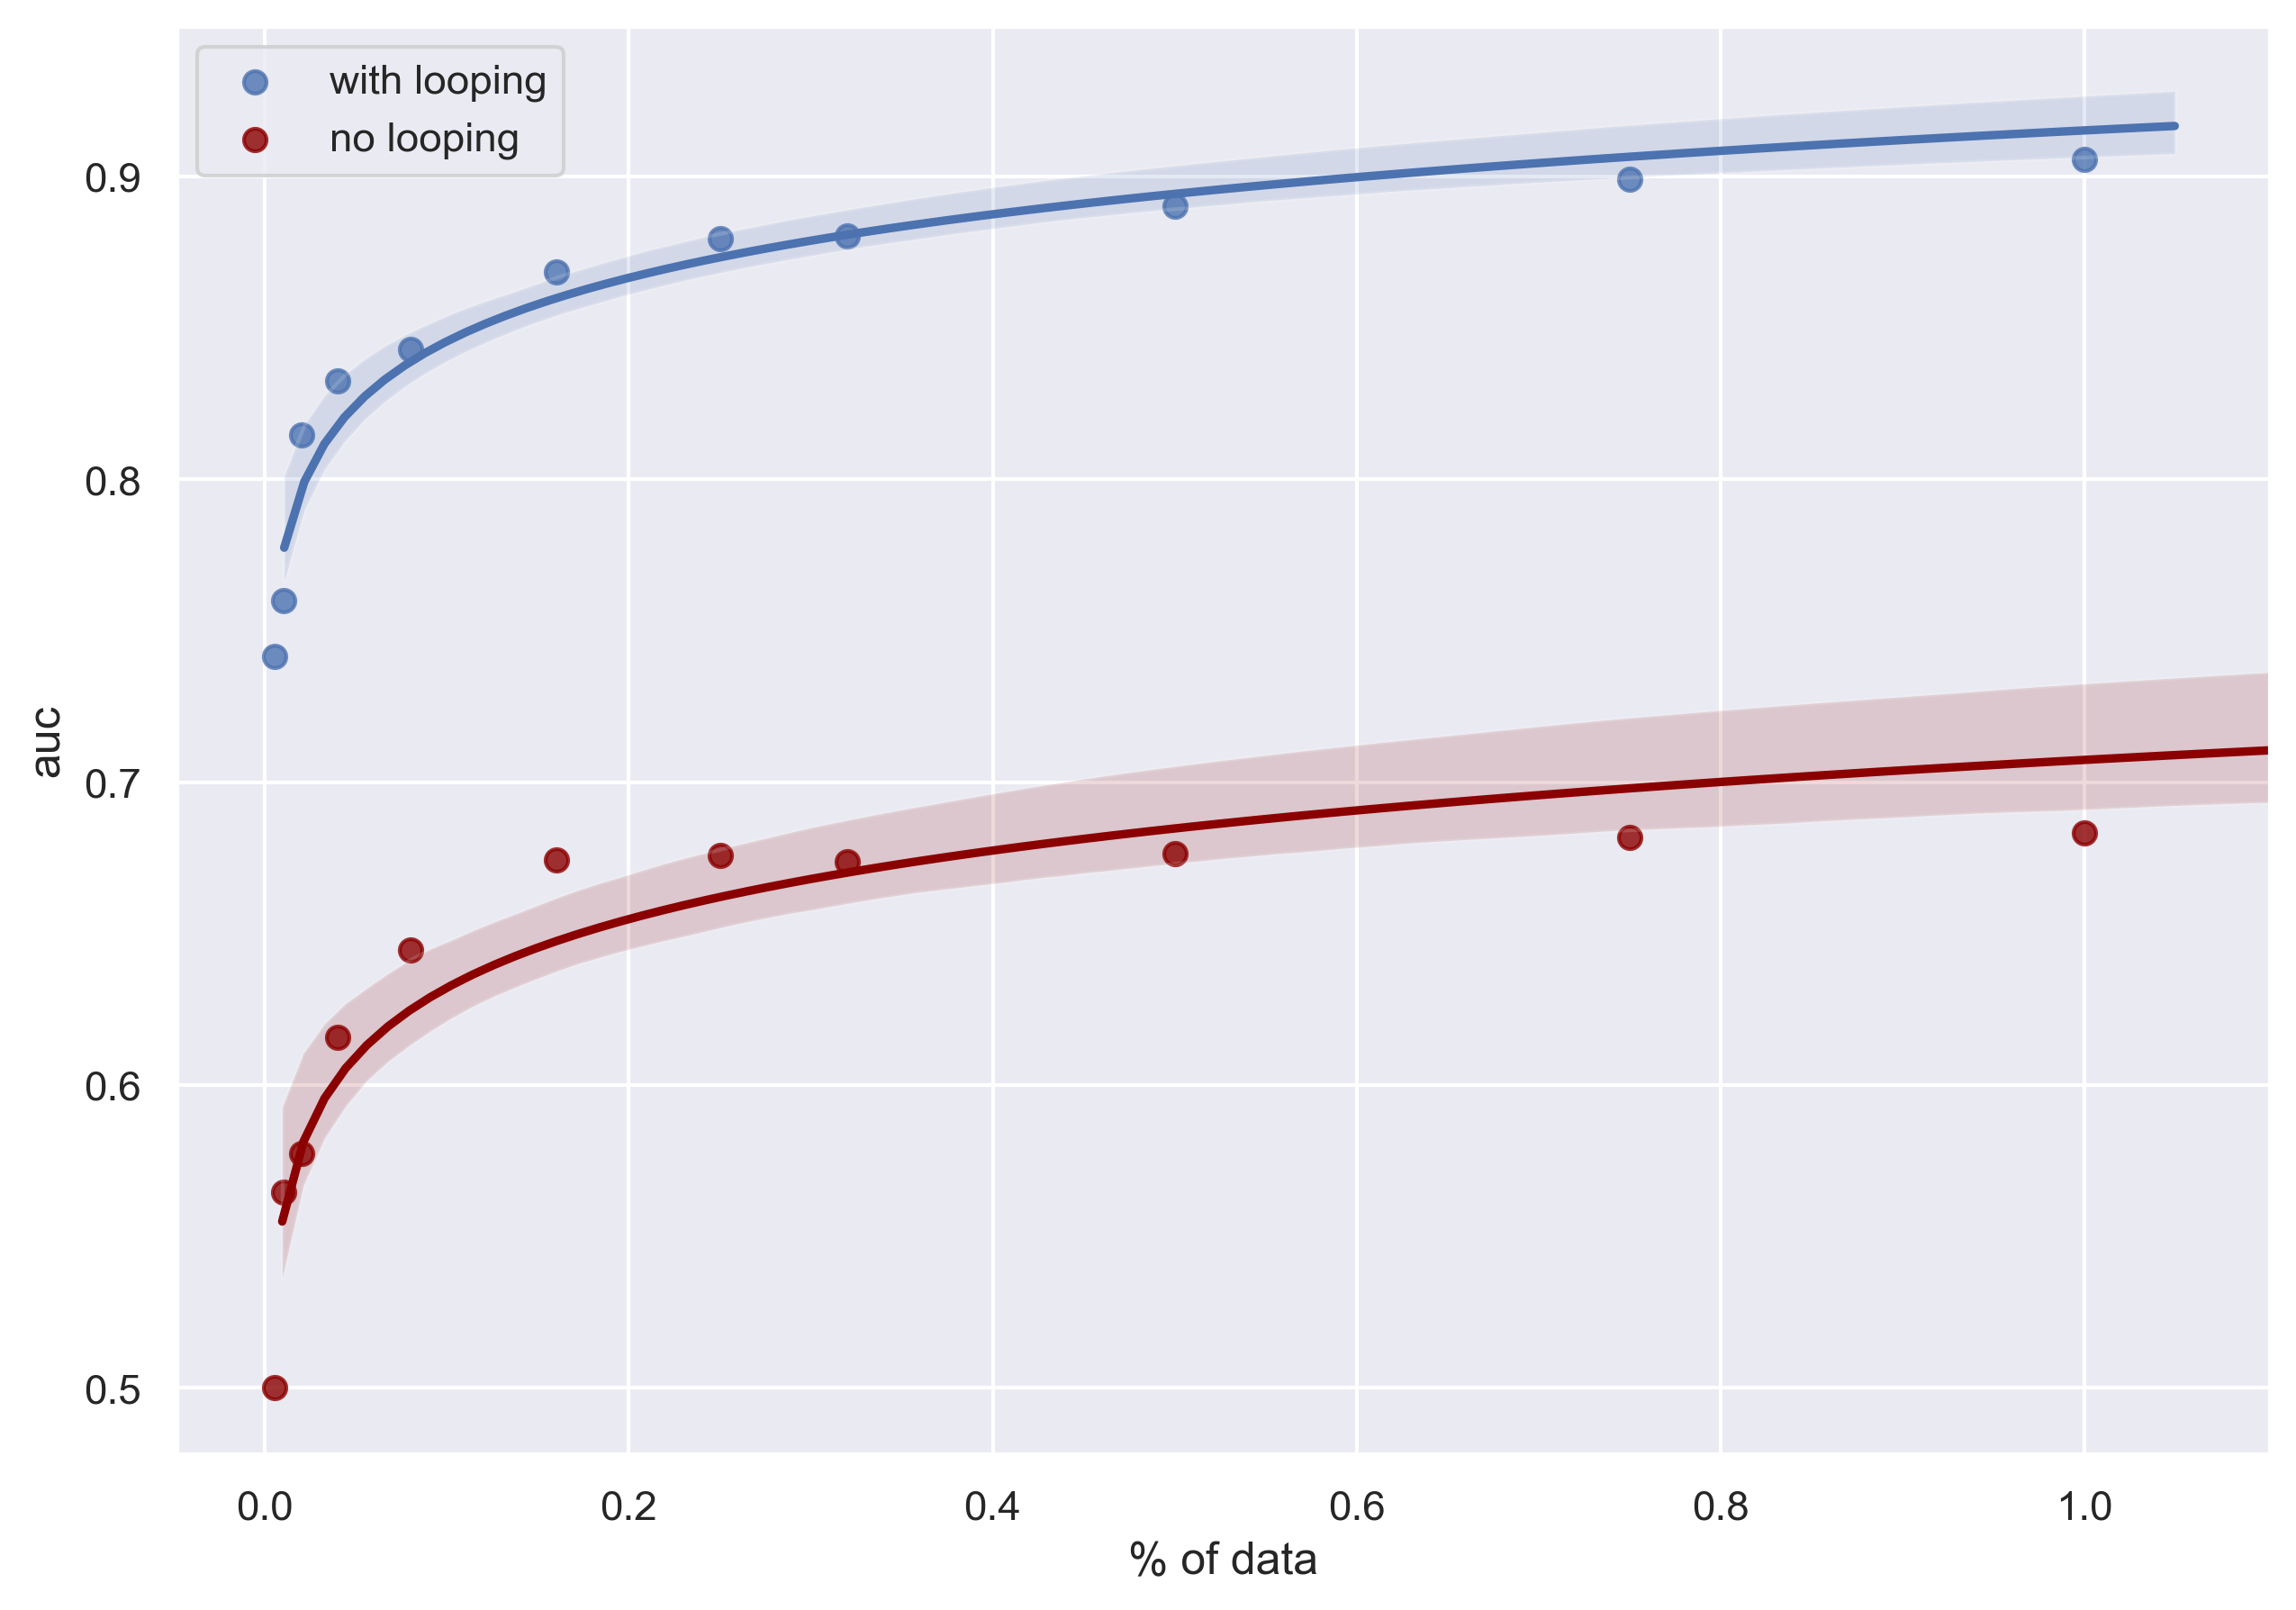

In [329]:
# sns.lineplot(x="perc", y="roc", data= pd.DataFrame.from_dict({'perc':perc_arr, 'roc':roc_arr}, orient='columns'))

comb_eval_df = pd.read_csv(os.path.join(save_dir, 'comb_eval_df.csv'))
prom_eval_df = pd.read_csv(os.path.join(save_dir, 'prom_eval_df.csv'))

fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=comb_eval_df,
           logx=True,ax=ax,label='with looping')
sns.regplot(x="perc", y="auc",data=prom_eval_df,
           logx=True,ax=ax,color='darkred',label='no looping')
ax.legend()
ax.set_xlabel('% of data')
fig.savefig(os.path.join(save_dir, '6A_eval_data_type_looping.pdf'))

In [291]:
prom_eval_df


,Unnamed: 0,perc,auc
0,0,0.005,0.500000
1,1,0.010,0.564706
2,2,0.020,0.577348
3,3,0.040,0.615764
4,4,0.080,0.644511
5,5,0.160,0.674250
6,6,0.250,0.675957
7,7,0.320,0.673638
8,8,0.500,0.676445
9,9,0.750,0.681876


(45855, 3)


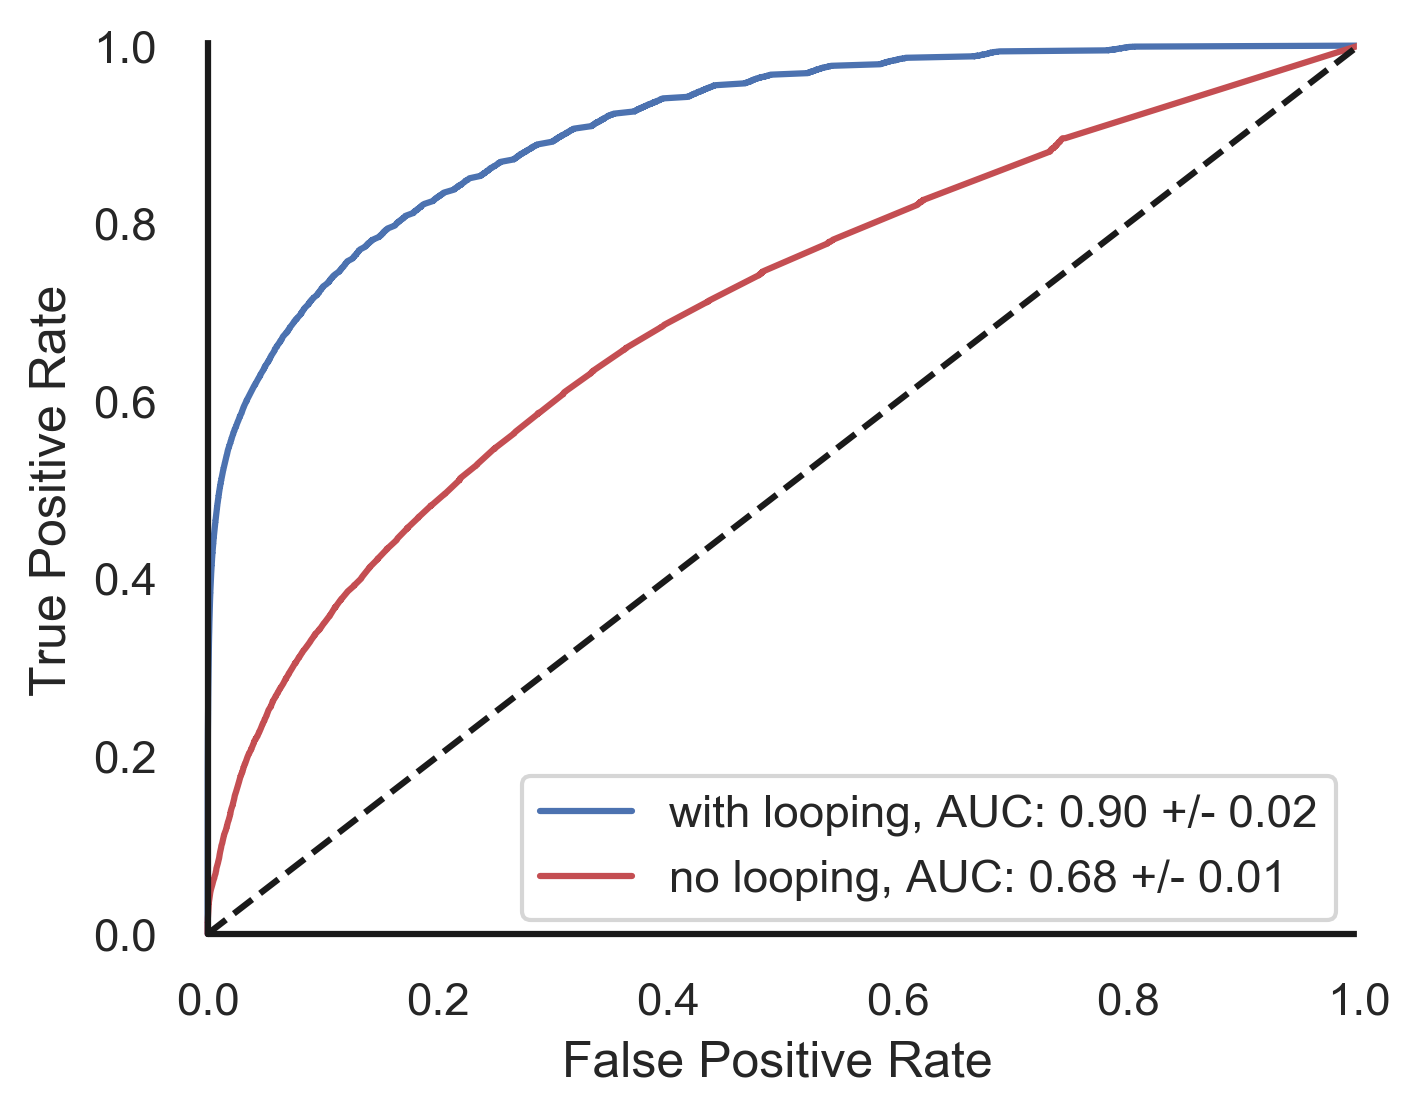

In [334]:
comb_auc_df = pd.read_csv(os.path.join(save_dir, 'comb_auc_curve_values.csv'))
prom_auc_df = pd.read_csv(os.path.join(save_dir, 'prom_auc_curve_values.csv'))
print(comb_auc_df.shape)
# with plt.style.context("seaborn-white"):
#     plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(5,4),dpi=300)
ax.set_facecolor('white')
ax.plot(comb_auc_df['fpr'], comb_auc_df['tpr'],'b-',label='with looping, AUC: 0.90 +/- 0.02')
ax.plot(prom_auc_df['fpr'], prom_auc_df['tpr'],'r-',label='no looping, AUC: 0.68 +/- 0.01')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim(-0.01,1)
ax.set_ylim(-0.01,1.01)

ax.plot([0, 1.1], [0, 0], 'k')
ax.plot([0, 0], [0, 1.1], 'k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# sns.scatterplot(x="fpr", y="tpr",data=comb_auc_df,
#                 marker=False,'-',
#            ax=ax,label='with looping')
# sns.scatterplot(x="fpr", y="tpr",data=prom_auc_df,
#                 marker=False,'-',
#            ax=ax,color='darkred',label='no looping')
ax.legend(loc='lower right',facecolor='white')
fig.savefig(os.path.join(save_dir, 'auc_comb_pro.pdf'))

# 4 Clustering

Dimensionality reduction 

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [30]:
# groups_dict = {'Airway':'purple',
#  'Astrocytes':'blue',
#  'Bladder':'purple',
#  'Colon':'green',
#  'Esophageal':'green',
#  'GDSD0':'purple',
#  'GDSD3':'purple',
#  'GDSD6':'purple',
#  'GM12878':'grey',
#  'HMEC':'purple',
#  'Melanocytes':'blue',
#  'Ovarian':'green',
#  'Pancreas':'green',
#  'Prostate':'purple',
#  'Renal':'green',
#  'Thyroid':'green',
#  'Uterine':'purple'}


In [31]:
cancer_mapping_dict={'A431-CTRLi': 'cancer',
 'CAL27-CTRLi': 'cancer',
 'GDSD0': 'normal',
 'GDSD3': 'normal',
 'GDSD6': 'normal',
 'SCC13-CTRLi':'cancer'}

In [32]:
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)
data_all_norm = pd.concat([data_all_norm, pd.Series(tissue_labels,name='tissue'),pd.DataFrame(genes_all,columns=['gene'])],axis=1)
data_all_norm['group'] = data_all_norm.tissue.map(cancer_mapping_dict)

In [33]:
Counter(data_all_norm.group)

Counter({'cancer': 39208, 'normal': 27829})

In [34]:
print(data_all_norm.shape)
data_all_norm

(67037, 583)


,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,BACH1_pro,...,SALL4_loop,NFE2_pro,NKX6-1_pro,ZIC1_pro,NFE2_loop,NKX6-1_loop,ZIC1_loop,tissue,gene,group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A431-CTRLi,A1BG,cancer
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A431-CTRLi,A3GALT2,cancer
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A431-CTRLi,A4GALT,cancer
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A431-CTRLi,A4GNT,cancer
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A431-CTRLi,AAAS,cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCC13-CTRLi,ZXDA,cancer
67033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCC13-CTRLi,ZYG11A,cancer
67034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCC13-CTRLi,ZYX,cancer
67035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCC13-CTRLi,ZZEF1,cancer


### 4A PCA

In [35]:
n_comp = 50
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm[data_all_varfilt_cols].values)


In [36]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

Explained variation per principal component: [0.22007716 0.02827579 0.01645038 0.01414777 0.01306138 0.01298982
 0.01143016 0.01069933 0.01011264 0.00942342 0.00882001 0.00847432
 0.00730478 0.00705275 0.00700531 0.00665527 0.00654133 0.00630504
 0.00592161 0.00578571 0.00559451 0.00531679 0.00517925 0.00509899
 0.00495784 0.00482725 0.00480945 0.00471602 0.00451525 0.0044656
 0.00437689 0.00427491 0.00416457 0.00409963 0.00395219 0.00386961
 0.00379463 0.00377887 0.00373479 0.00368756 0.00363317 0.00357701
 0.00355015 0.00346162 0.00345245 0.00338104 0.00332496 0.0033089
 0.00326192 0.00318896]


0.539888767435792

In [37]:
for i in range(n_comp):
    data_all_norm['pc_'+str(i+1)] = pca_result[:,i]


In [38]:
data_all_norm.shape

(67037, 633)

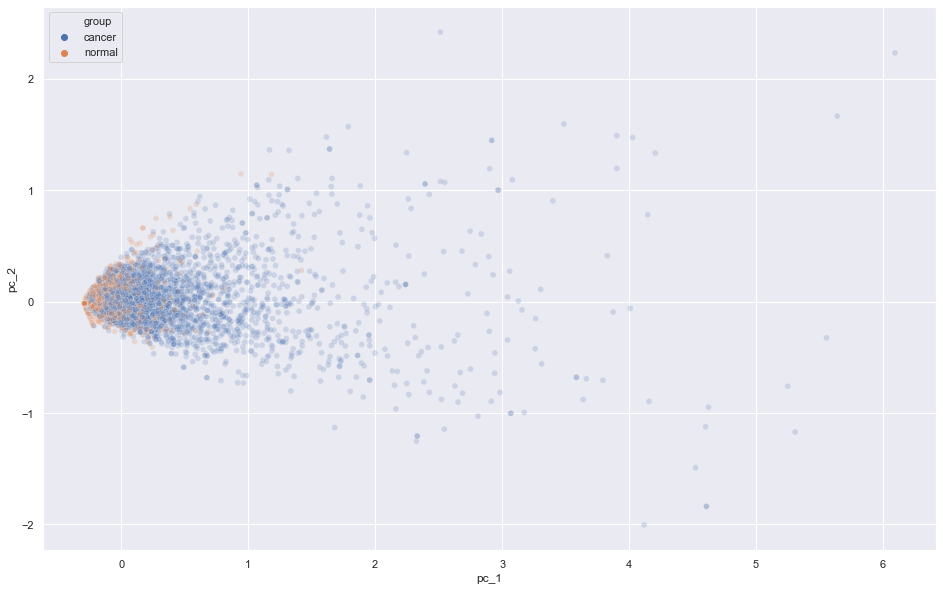

In [39]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
# idx_choice = range(len(data_all_norm))#np.random.choice(data_all_norm.index.values, 10000)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.2
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12.png'))

In [71]:
# figure out what's responsible for a pc space
pc1_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_1_coeff':pca.components_[0]})#,orient='index')
pc1_df['pc_1_coeff_abs'] = abs(pc1_df['pc_1_coeff'])
pc1_df = pc1_df.sort_values('pc_1_coeff_abs',ascending=False)
pc1_df[:10]

,features,pc_1_coeff,pc_1_coeff_abs
297,KLF5_loop,0.111867,0.111867
373,SP2_loop,0.109503,0.109503
298,KLF6_loop,0.107843,0.107843
249,EGR1_loop,0.103602,0.103602
247,E2F6_loop,0.103504,0.103504
258,ETS1_loop,0.102052,0.102052
332,NR2F2_loop,0.102031,0.102031
374,SP3_loop,0.102006,0.102006
351,RBPJ_loop,0.101427,0.101427
438,ZNF770_loop,0.100874,0.100874


In [40]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

,features,pc_2_coeff,pc_2_coeff_abs
263,FOSL1_loop,0.169206,0.169206
261,FOS_loop,0.167948,0.167948
264,FOSL2_loop,0.164602,0.164602
274,FOXP1_loop,0.161607,0.161607
294,JUND_loop,0.156506,0.156506
...,...,...,...
66,HSF2_pro,0.000031,0.000031
122,PBX2_pro,-0.000030,0.000030
85,MECOM_pro,-0.000015,0.000015
554,ZFP42_loop,-0.000007,0.000007


In [41]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene.png'))

### 4B: tsne

In [42]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
# idx_choice = range(len(data_all_norm))#np.random.choice(data_all_norm.index.values, 10000)
data_all_norm_df_subset = data_all_norm.loc[idx_choice]

In [43]:
Counter(data_all_norm_df_subset.group)

Counter({'cancer': 5906, 'normal': 4094})

In [44]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 5.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.174164
[t-SNE] KL divergence after 300 iterations: 2.965003
t-SNE done! Time elapsed:

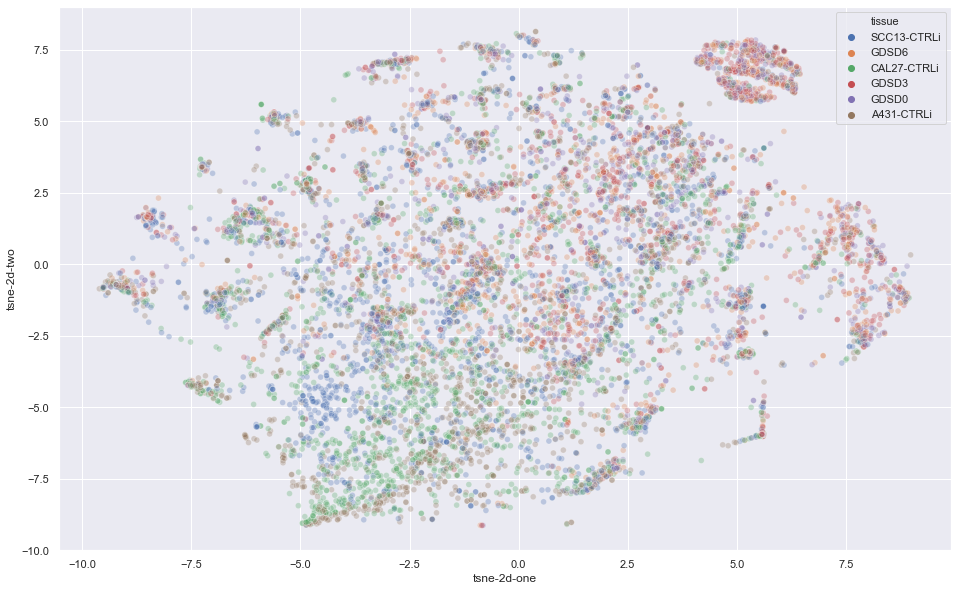

In [54]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2_tissue.png'))

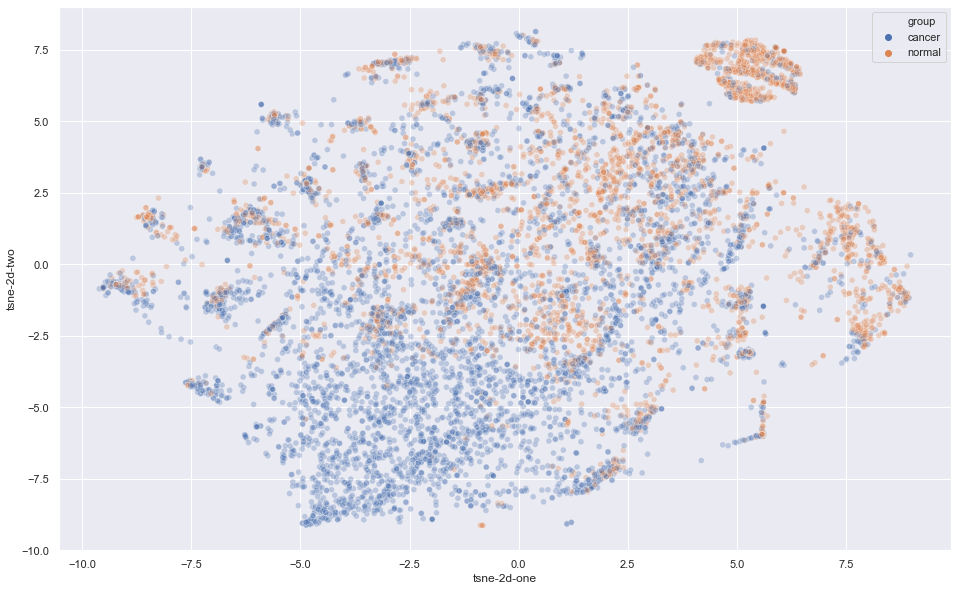

In [46]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [51]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[idx_choice,:])
embedding.shape

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 21.6 s, sys: 529 ms, total: 22.1 s
Wall time: 18 s


(10000, 2)

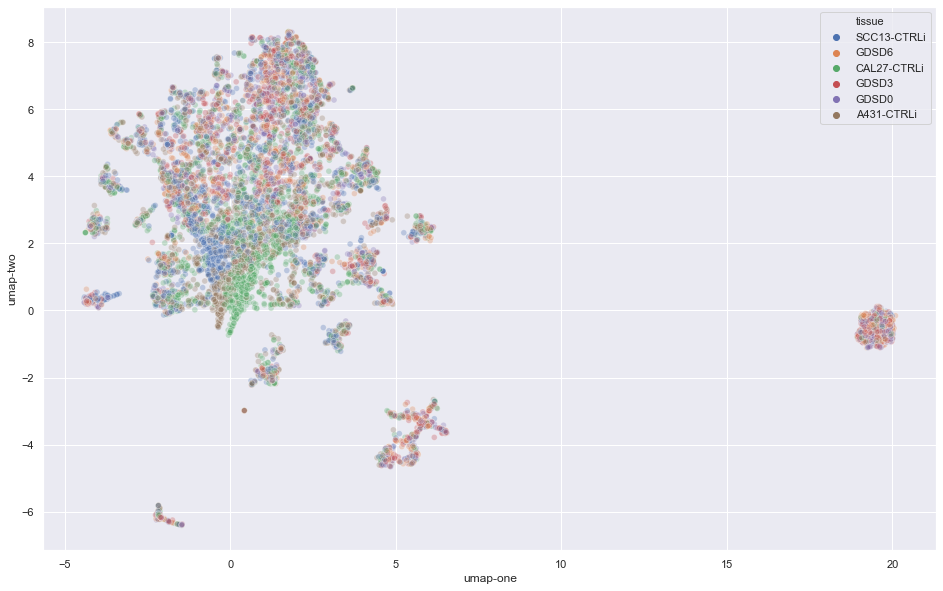

In [55]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap_tissue.png'))

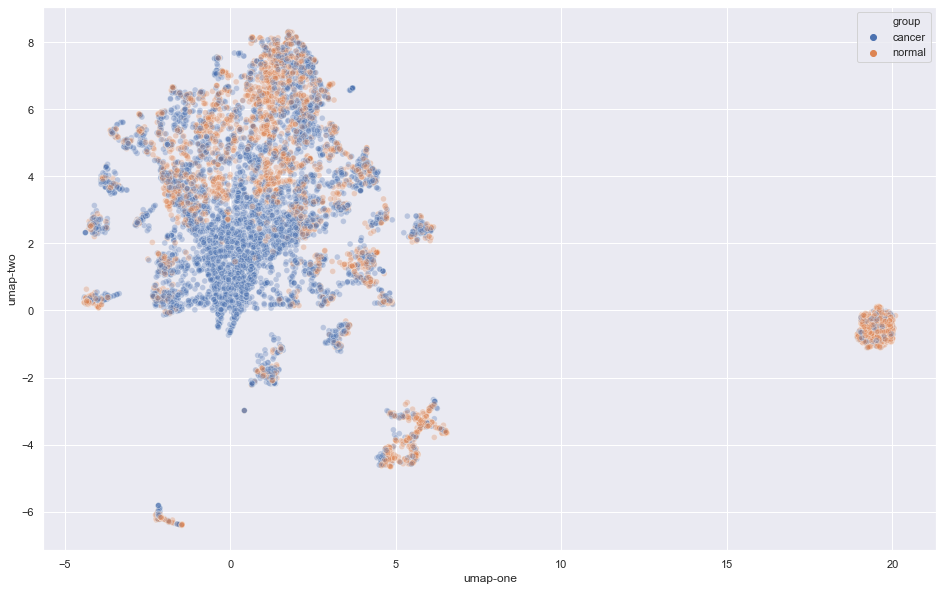

In [56]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [58]:
gene_variance_df = data_all_norm_df_subset.groupby('gene').agg({
    'umap-one':'std','umap-two':'std'
}).dropna()
gene_variance_df['sq_var'] = gene_variance_df.apply(lambda x: np.sqrt(x['umap-one']**2 + x['umap-two']**2),axis=1)
gene_variance_df.sort_values('sq_var',inplace=True)

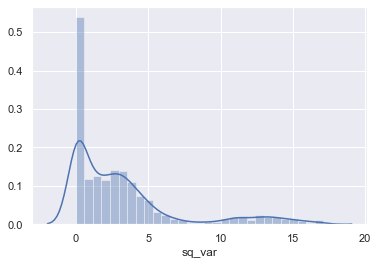

In [59]:
sns.distplot(gene_variance_df.sq_var)

In [60]:
low_var_genes = gene_variance_df.index[gene_variance_df.sq_var < 1]
med_var_genes = gene_variance_df.index[(gene_variance_df.sq_var >= 1)&(gene_variance_df.sq_var < 7) ]
high_var_genes = gene_variance_df.index[gene_variance_df.sq_var >= 7]
len(low_var_genes), len(med_var_genes), len(high_var_genes)

(795, 1128, 268)

In [65]:
for x in high_var_genes:
    print(x)

LZTR1
CXXC5
ANKK1
SALL2
RMND5B
PTBP2
PTPN4
FIP1L1
IL34
HOXD12
SCNN1G
CDK16
CREB3L2
PDE6G
CENPJ
TEX261
WEE2
CSF2
IFT27
DRD5
P2RY13
LAMB2
TCTN2
LAPTM4A
SSH2
MPP2
ASB15
ZNF250
PPM1E
LACC1
NISCH
ANKRD52
TSTD1
LRBA
RDH5
GRHPR
HERC4
NF2
LILRA6
EGR4
PAPOLG
SPATA3
ATAT1
RPL9
CCT4
INPP5A
PIGB
EFCAB5
ATP1B3
NTN3
FAM199X
TLR8
UNC50
CDK13
GLTPD2
PIK3R3
RALBP1
SCUBE2
EPS15
TRIML2
MIS18A
MAP4K2
FBXO42
TPRX1
HSPA9
RAB40B
MRTO4
MMS19
MAP1LC3C
VPS45
GLI2
RTBDN
TMEM92
MPHOSPH6
GCM2
APLNR
EEF1G
FANK1
LSM11
ANKLE1
GPT
KRBOX1
AFTPH
MRGPRG
FOXP4
SMAGP
INS
RPP25
GPATCH8
CLSTN3
HIPK1
TGS1
YIF1A
PPP2R5A
RAD23A
ELMSAN1
SPINK8
BMPR2
KRT27
PIAS1
HOOK1
AGPS
BRIP1
USP38
MC1R
SSTR4
USP24
OR1M1
PPP2CA
PPP2R3C
GCH1
CHN1
USP11
NDUFAF7
PBLD
BAZ2B
USP36
ODF1
MGST3
CX3CL1
WIF1
ATP8B2
ADAMTS6
CTCFL
MSC
MDN1
WWC2
GALK2
KCNF1
REP15
UMODL1
RHBDD2
FAM43A
SUV39H2
LEPROT
MED29
FNDC3A
GBE1
MITD1
NR2C2
ARHGAP31
KIF3C
LSM1
SLC2A12
COA5
PTX3
BRD3
ARHGEF18
DONSON
ERBB3
CAPN7
ZNF333
ITGB2
OR1J1
GRID2IP
PIK3IP1
CRABP1
CBWD1
DNAJC30
ZBT

In [85]:
# cluster_one = sorted(set(data_all_norm_df_subset[data_all_norm_df_subset['umap-one']>10]['gene'].values))
# print(len(cluster_one))
# for x in cluster_one:
#     print(x)

1876
A4GALT
AADACL4
AAMDC
AAR2
AARS2
AARSD1
ABCA13
ABCA4
ABCB1
ABCB5
ABCC1
ABCC4
ABCC8
ABCD1
ABCG1
ABCG2
ABHD13
ABHD16B
ABHD17A
ABHD2
ABHD3
ABI3BP
ACAT2
ACER1
ACHE
ACKR2
ACOT1
ACOT8
ACOX3
ACOXL
ACSL4
ACSM2A
ACTG2
ACTR1B
ACTR8
ACTRT3
ACVR1
ADAM10
ADAM17
ADAM19
ADAM28
ADAM9
ADAMDEC1
ADAMTS1
ADAMTS12
ADAMTS14
ADAMTS17
ADAMTS8
ADD3
ADH5
ADHFE1
ADIPOR2
ADIRF
ADNP2
ADORA1
ADPRHL1
ADTRP
AEBP2
AFMID
AGFG2
AHCTF1
AHCY
AHCYL2
AHR
AIM2
AIMP1
AK1
AK5
AK7
AKAP12
AKAP7
AKAP9
ALDH1B1
ALDH3B1
ALG3
ALKBH7
ALOX15
ALX1
AMBN
AMIGO1
AMIGO2
ANKK1
ANKRD1
ANKRD17
ANKRD23
ANKRD34B
ANKRD42
ANKRD44
ANKRD45
ANKRD61
ANO4
ANO7
ANTXR1
ANTXR2
AOC3
AOX1
AP3B2
AP3M1
AP3M2
AP4B1
AP5M1
APAF1
APBA1
APIP
APOBEC3G
APOE
APOL1
APOL3
APP
APPL2
AQP11
AQP5
AQP6
ARAF
ARF3
ARFGEF1
ARG2
ARHGAP18
ARHGAP22
ARHGAP31
ARHGAP5
ARHGEF1
ARHGEF38
ARID4B
ARL4A
ARMC3
ARNT
ARNTL
ARSI
ARSJ
ART4
ARX
ASAP1
ASCL4
ASGR1
ASIC1
ASPHD1
ASPHD2
ASRGL1
ASTE1
ATF1
ATF2
ATF7IP2
ATG7
ATP10D
ATP11C
ATP12A
ATP13A1
ATP2B1
ATP2B3
ATP2C1
ATP6V0C
ATP6V1H
ATP8B1
A

In [62]:
data_all_norm_df_subset['var_group'] = 'none'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(low_var_genes)]='low_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(med_var_genes)]='med_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(high_var_genes)]='high_var'

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

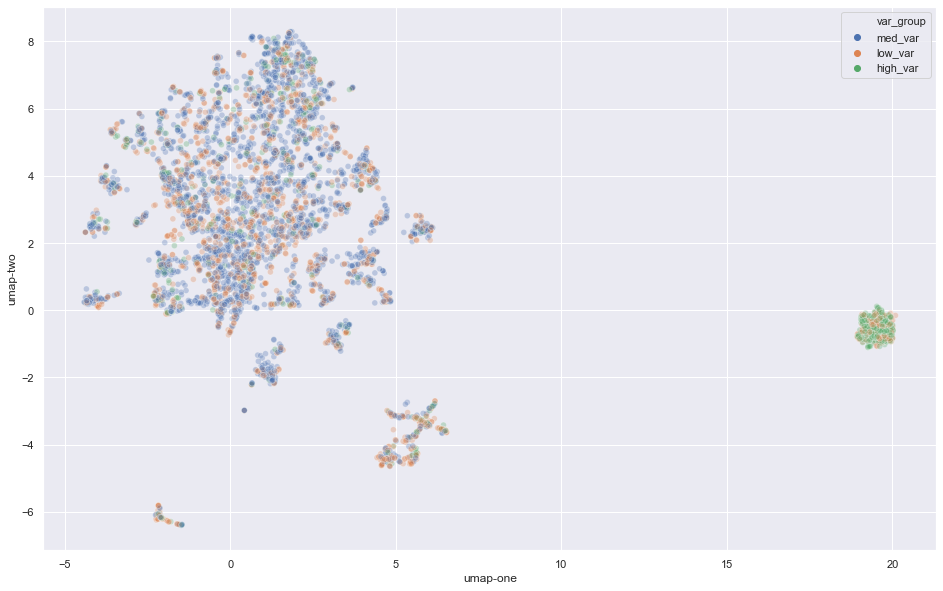

In [64]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="var_group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset[data_all_norm_df_subset.var_group!='none'],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap_vargroup.png'))